# Online classifier comparison

This notebook takes a single epoch from either the MOABB or the pediatric dataset and computes the classification running a preset number of voters. The execution time is measured.
The end part of the notebook can do the plot of the accuracy vs number voters.

## Import libraries


# RESULTS HERE ARE USING "STANDARD NUMPY" for CPU operations on MacOS with M2 Max Macbook Pro

In [1]:
# Default libraries
import re
import mne
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from moabb.datasets import Wang2016, SSVEPExo
from moabb.paradigms import FilterBankSSVEP, SSVEP
from moabb.pipelines import ExtendedSSVEPSignal
from sklearn.linear_model import LogisticRegression
from moabb.evaluations import CrossSubjectEvaluation

import time
# from cupyx.profiler import benchmark

# Import custom libraries
from functions import data_tools
from functions import processing
from functions import classification
from functions.FeatureExtractorSSVEP import FeatureExtractorCCA as CCA
from functions.FeatureExtractorSSVEP import FeatureExtractorMSI as MSI
from functions.FeatureExtractorSSVEP import FeatureExtractorMEC as MEC

# Magic command to reload libraries
%reload_ext autoreload

## General settings

In [2]:
# Create linear distribution of voters
# n_voters = np.linspace(1, 100, 5, dtype=int)
n_voters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 50, 75, 100, 150, 200, 500, 750, 1000]
n_epochs = 1   # Number of epochs to be used in the classification


test_dataset = "Wang2016"    # "Wang2016" or "BCI4Kids"
dataset_nsubjects = {
    "Wang2016": 34,
    "BCI4Kids": 6
}
# Generate random indexes
random_seed = 42
# random.seed(random_seed)
# subject = random.randint(0, dataset_nsubjects[dataset] - 1, random_seed)


# Classifier settings 
harmonic_count = 2

# Create dataframes for each classifier
columns = {
    'n_voters': n_voters,
    'CPU_time': np.nan,
    'CPU_accuracy': np.nan,
    'GPU_time': np.nan,
    'GPU_accuracy': np.nan
    }
cca_df = pd.DataFrame(columns)
# msi_df = pd.DataFrame(index=n_voters, columns=['CPU_time', 'CPU_prediction', 'GPU_time', 'GPU_prediction'])
# mec_df = pd.DataFrame(index=n_voters, columns=['CPU_time', 'CPU_prediction', 'GPU_time', 'GPU_prediction'])
# rg_logreg_df = pd.DataFrame(index=n_voters, columns=['CPU_time', 'CPU_prediction', 'GPU_time', 'GPU_prediction'])

# Data

Get a randomized single epoch from a single trial in the selected dataset

In [3]:
if (test_dataset == "Wang2016"):
    # Get trial data
    dataset = Wang2016()
    subject_data = dataset.get_data(subjects=[1])
    time_trim = [0.5, 5.5] # Times to trim the data [sec]
    stimulus_freqs = [float(freq) for freq in dataset.event_id.keys()]  # Stimulus frequencies [Hz]
    srate = subject_data[1]["0"]["0"].info['sfreq'] # Sampling rate [Hz]

    # Frequency bands
    first_column = np.arange(1, 11) * 8
    second_column = np.full(10, 88)
    cca_subbands = np.column_stack((first_column, second_column))

    # Get epoched data
    # - Preallocate data
    epochs_list = [None] * len(subject_data)
    events_list = [None] * len(subject_data)

    # - Obtain epochs and events
    for s, subject in subject_data.items():
        [events_list[s-1], epochs_list[s-1]] = data_tools.moabb_events_to_np(
            mne_raw = subject["0"]["0"],
            tmin = time_trim[0],
            tmax = time_trim[1],
            events_dict = dataset.event_id,
            )
        
    # - Convert lists to np.ndarrays
    eeg_channels = subject_data[1]["0"]["0"].ch_names
    epochs_np = np.float32(np.array(epochs_list))
    events_np = np.array(events_list[0][:,2]) - 1   # The `-1` is to make the labels start at 0

    # - Remove stim channel and pick subset of epochs
    eeg_channels = eeg_channels[:-1]
    epochs_np = epochs_np[:, :, :-1, :]
    n_samples = epochs_np.shape[-1]

    # - Get randomized subset of epochs
    total_n_epochs = epochs_np.shape[1]
    epochs_subset = random.sample(range(total_n_epochs), n_epochs)
    # epochs_subset = 0
    # epochs = np.float32(epochs_np)
    epochs = np.float32(epochs_np[:,epochs_subset,:,:])



Trial data de-meaned and concatenated with a buffer to create continuous data


# Setup classifiers

In [4]:
cca_voters = 1
cca_gpu = False
cca = CCA()
def setup_cca():
    cca.setup_feature_extractor(
        harmonics_count = harmonic_count,
        targets_frequencies = stimulus_freqs,
        sampling_frequency = srate,
        samples_count = n_samples,
        filter_order = 12,
        subbands = cca_subbands,
        voters_count = cca_voters,
        use_gpu = cca_gpu,
        random_seed = random_seed,
        max_batch_size = 256
        )
    
    return cca
    
mec = MEC()
def setup_mec(voters, use_gpu):
    # Missing implementation
    pass

msi = MSI()
def setup_msi(voters, use_gpu):
    # Missing implementation
    pass

## CPU classification

### CCA

In [5]:
# Classify epoch with varying number of voters
print("CCA CPU processing")
for (v, voters) in enumerate(n_voters):
    temp_times = np.zeros(n_epochs)
    temp_accuracy = 0

    for e, epoch in enumerate(epochs_subset):
        start_time = time.time()

        # Set up classifier and extract features
        cca_voters = voters
        cca_gpu = False
        setup_cca()    
        cca_features = np.squeeze(cca.extract_features(epochs[:,e,:,:]))        

        # Find max correlation across subbands and voters
        if (voters == 1):
            temp_prediction = np.argmax(np.max(cca_features, axis=0), axis=0)
        else:
            temp_prediction = np.argmax(np.max(cca_features, axis=(0,1)), axis=0)

        end_time = time.time()
        temp_times[e] = end_time - start_time
        print(f"- voters: {voters} in {temp_times[e]:.2f} sec")

        temp_accuracy += 1 if temp_prediction == events_np[epoch] else 0

    cca_df.loc[v, "CPU_time"] = temp_times.mean()
    cca_df.loc[v, "CPU_accuracy"] = temp_accuracy / n_epochs

CCA CPU processing
- voters: 1 in 0.24 sec
- voters: 2 in 0.16 sec
- voters: 3 in 0.18 sec
- voters: 4 in 0.23 sec
- voters: 5 in 0.26 sec
- voters: 6 in 0.31 sec
- voters: 7 in 0.30 sec
- voters: 8 in 0.34 sec
- voters: 9 in 0.37 sec
- voters: 10 in 0.39 sec
- voters: 15 in 0.51 sec
- voters: 20 in 0.55 sec
- voters: 25 in 0.72 sec
- voters: 50 in 1.12 sec
- voters: 75 in 1.59 sec
- voters: 100 in 2.08 sec
- voters: 150 in 2.90 sec
- voters: 200 in 3.91 sec
- voters: 500 in 9.22 sec
- voters: 750 in 13.65 sec
- voters: 1000 in 17.87 sec


## GPU classification

### CCA

## Visualization

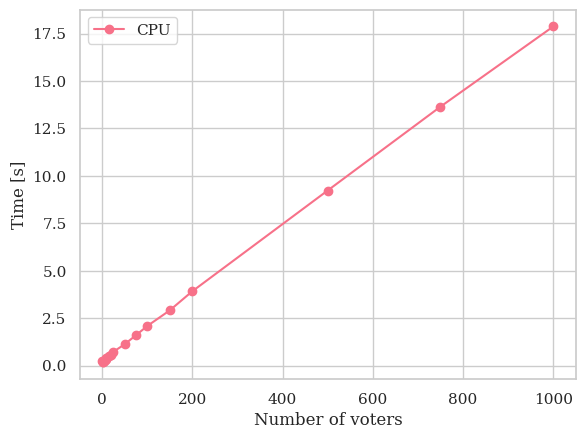

In [6]:
fig, ax = plt.subplots(1, 1,)
ax.plot(cca_df["n_voters"], cca_df["CPU_time"], label="CPU", marker='o')
# ax.plot(cca_df["n_voters"], cca_df["GPU_time"], label="GPU", marker='*')
ax.set_xlabel("Number of voters")
ax.set_ylabel("Time [s]")
ax.legend()